# Analysis of Heart Disease Data to Predict Likelihood of Disease in an Individual.


# Introduction
Heart disease is the second most common cause of death in Canada and research shows that lifestyle modifications and medication, can significantly lower your chance of developing the disease. In this analysis, we will aim to answer the question: what factors can help us predict whether an individual will have heart disease? To answer this question, we will be using a heart disease dataset that has information on 303 patients with 14 columns containing data about different medical information. The class we want to predict is whether heart disease is present in an individual based on evaluating three predictors: cholesterol levels, blood pressure levels, and age, which are all known to affect the probability of a patient being diagnosed with heart disease.

# Exploratory Data Analysis

In [34]:
#Demonstrate that the dataset can be read from the web into R
 #read data 
library(tidyverse)
library(tidymodels)
heart_disease <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
    #rename columns
    names(heart_disease) <- c("age", "sex", "chest_pain", "blood_pressure", "cholesterol", "blood_sugar", "EKG", "heart_rate", "angina", "ST_depression", "ST_slope", "fluro", "thallium", "presence_of_disease")


In [35]:
disease_data <- heart_disease |>
    #make whether or not a patient has the disease a fct
    mutate (disease_presence = as_factor(presence_of_disease))|>
    #select the three predictors that we want to examine
    select (age, blood_pressure, cholesterol, disease_presence)
 #display the first 9 rows of the data
head(disease_data, n = 9)

,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
1,67,160,286,2
2,67,120,229,1
3,37,130,250,0
4,41,130,204,0
5,56,120,236,0
6,62,140,268,3
7,57,120,354,0
8,63,130,254,2
9,53,140,203,1


We renamed the columns with names that we can understand, then selected the four columns that we are interested in examining: cholesterol levels, blood pressure levels, age and presence of heart disease.

In [36]:
#Clean and wrangle your data into a tidy format
    #make column of disease presence binary (by making all values bigger than 1 equal to 1) 
disease_data$disease_presence <-ifelse(disease_data$disease_presence=="0",0,1)
disease_data <- disease_data |>
    #make disease presence a factor again since it was transformed into a double case
    mutate (disease_presence =as_factor(disease_presence))
    head(disease_data, n = 9)   

,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
1,67,160,286,1
2,67,120,229,1
3,37,130,250,0
4,41,130,204,0
5,56,120,236,0
6,62,140,268,1
7,57,120,354,0
8,63,130,254,1
9,53,140,203,1


In [37]:
    #split data into training and testing so we can use training data seperatly
disease_split <- initial_split(disease_data, prop = 0.75, strata = disease_presence)  
disease_training <- training(disease_split)   
disease_testing <- testing(disease_split)
  head(disease_training, n = 3)
  head(disease_testing, n = 3)

,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
3,37,130,250,0
4,41,130,204,0
5,56,120,236,0


,age,blood_pressure,cholesterol,disease_presence
,<dbl>,<dbl>,<dbl>,<fct>
6,62,140,268,1
8,63,130,254,1
19,49,130,266,0


Having the presence of heart disease be a binary factor will allow us to better visualize the data later. 
Splitting the data is necessary because the training data is what is used to build the classifier, and the testing data is what we are trying to predict.

In [38]:
#We created a table that groups the data into individuals who present heart disease and those who don't, and allows us to see the difference between the means of the three data columns that we are intereted in. 
disease_summary <- disease_training |> 
    group_by(disease_presence)|>
    summarize(avg_age=mean(age), avg_blood_pressure=mean(blood_pressure), avg_cholesterol=mean(cholesterol))
disease_summary

disease_presence,avg_age,avg_blood_pressure,avg_cholesterol
<fct>,<dbl>,<dbl>,<dbl>
0,52.40164,129.9590,243.1475
1,56.86538,134.5769,255.4615


This summary of the data shows the mean value of our predictors of individuals with heart disease (1) and without (0), allowing us to compare the values. 


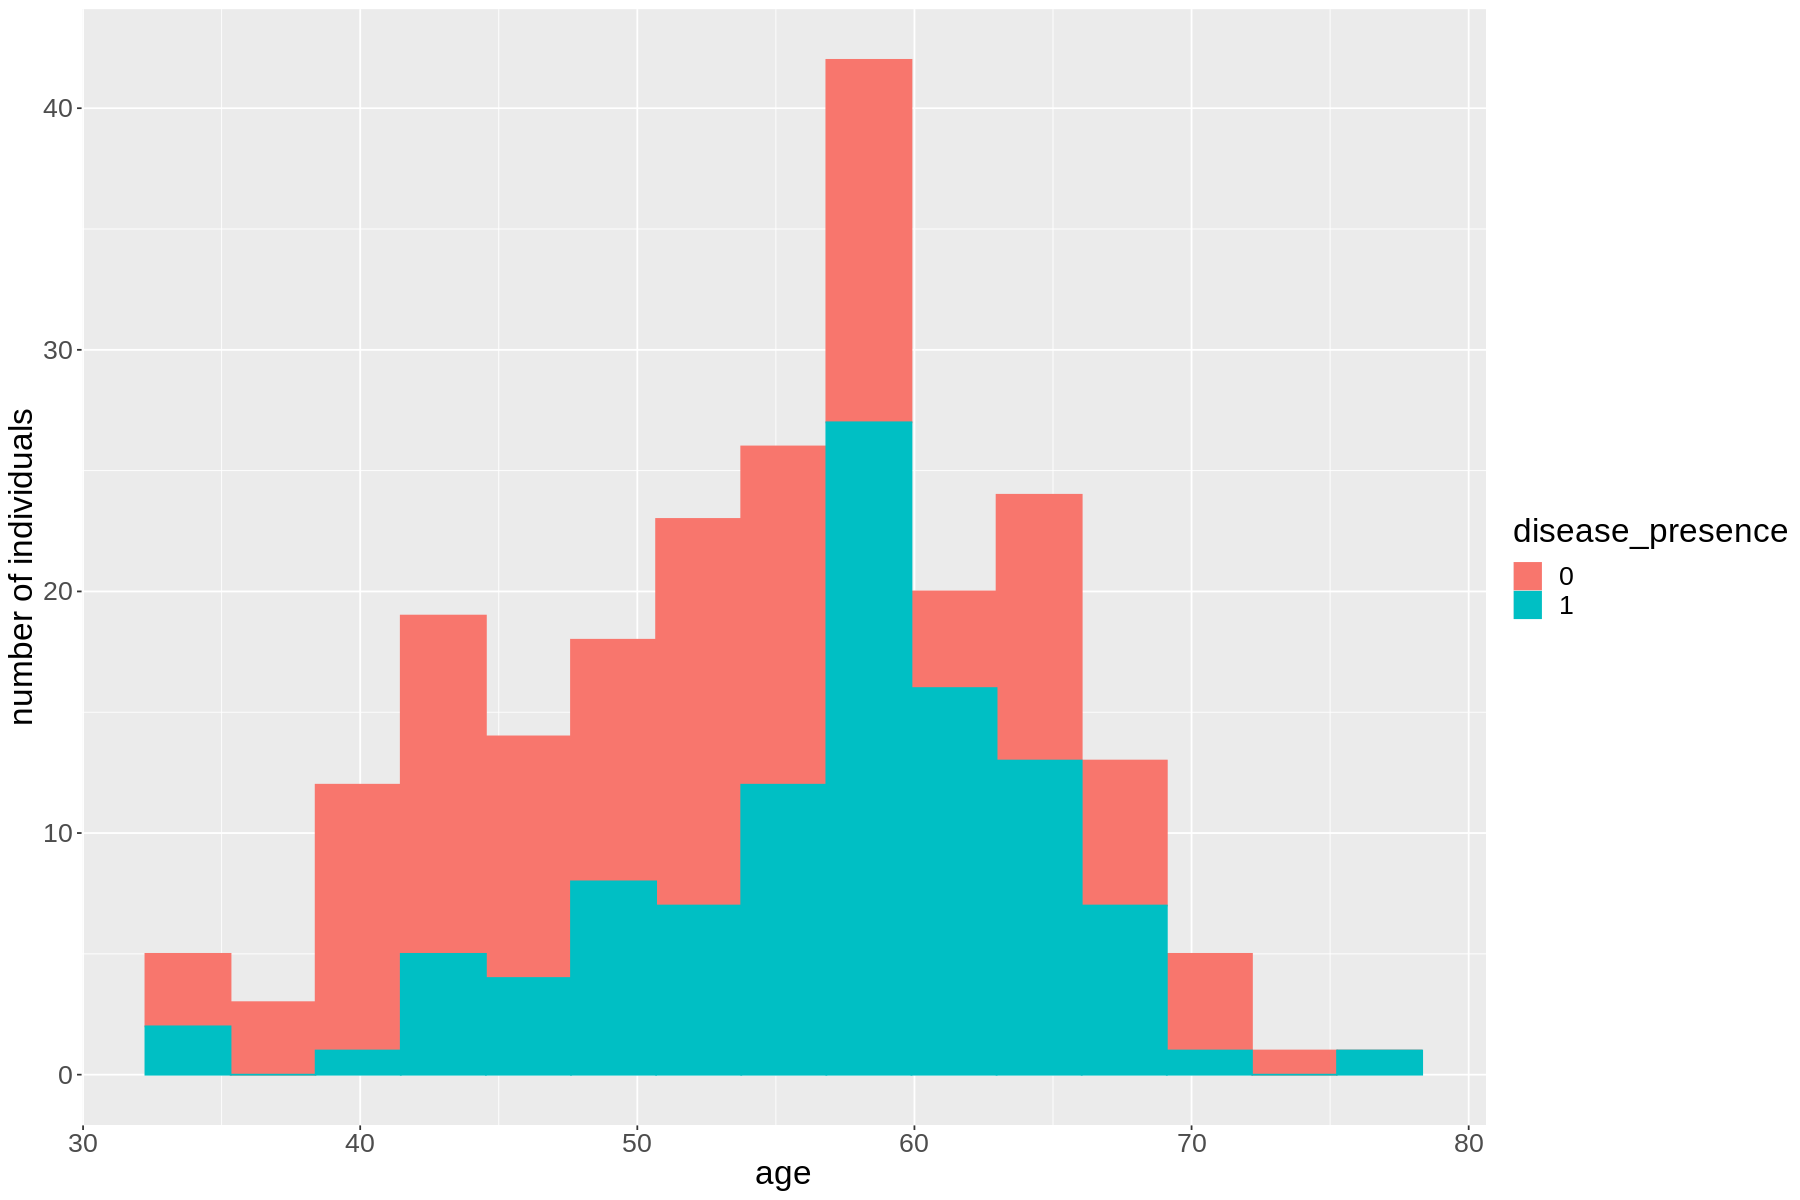

In [39]:
# the distributions of each of the predictor variables.
options(repr.plot.width = 15, repr.plot.height = 10)
disease.age_plot <- ggplot(disease_training, aes(x=age, fill=disease_presence, color=disease_presence)) +
          geom_histogram(bins=15)+
          xlab("age") +
          ylab("number of individuals") + 
          theme(text = element_text(size = 20)) 
disease.age_plot

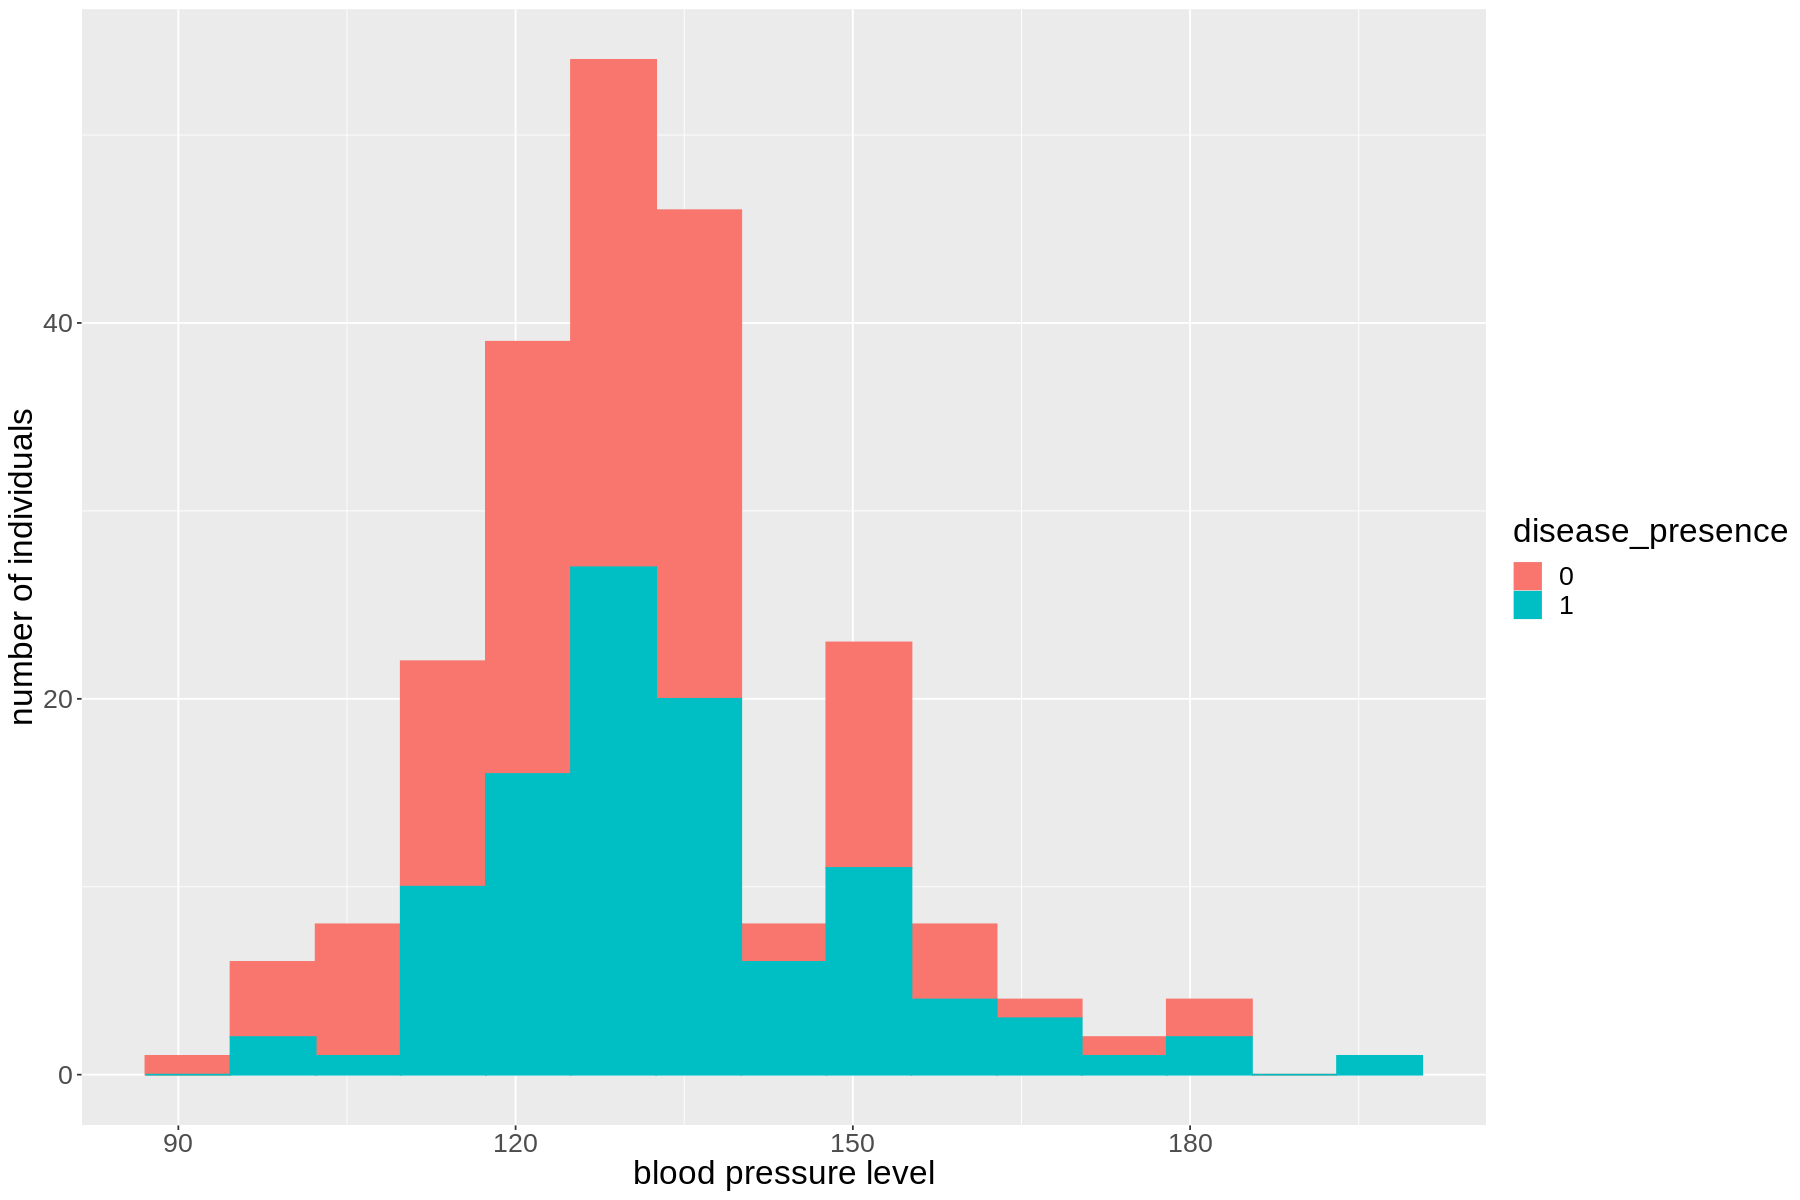

In [40]:
options(repr.plot.width = 15, repr.plot.height = 10)
disease.bloodpressure_plot <- ggplot(disease_training, aes(x=blood_pressure, fill=disease_presence, color=disease_presence)) +
          geom_histogram(bins=15)+
          xlab("blood pressure level") +
          ylab("number of individuals") + 
          theme(text = element_text(size = 20)) 
disease.bloodpressure_plot

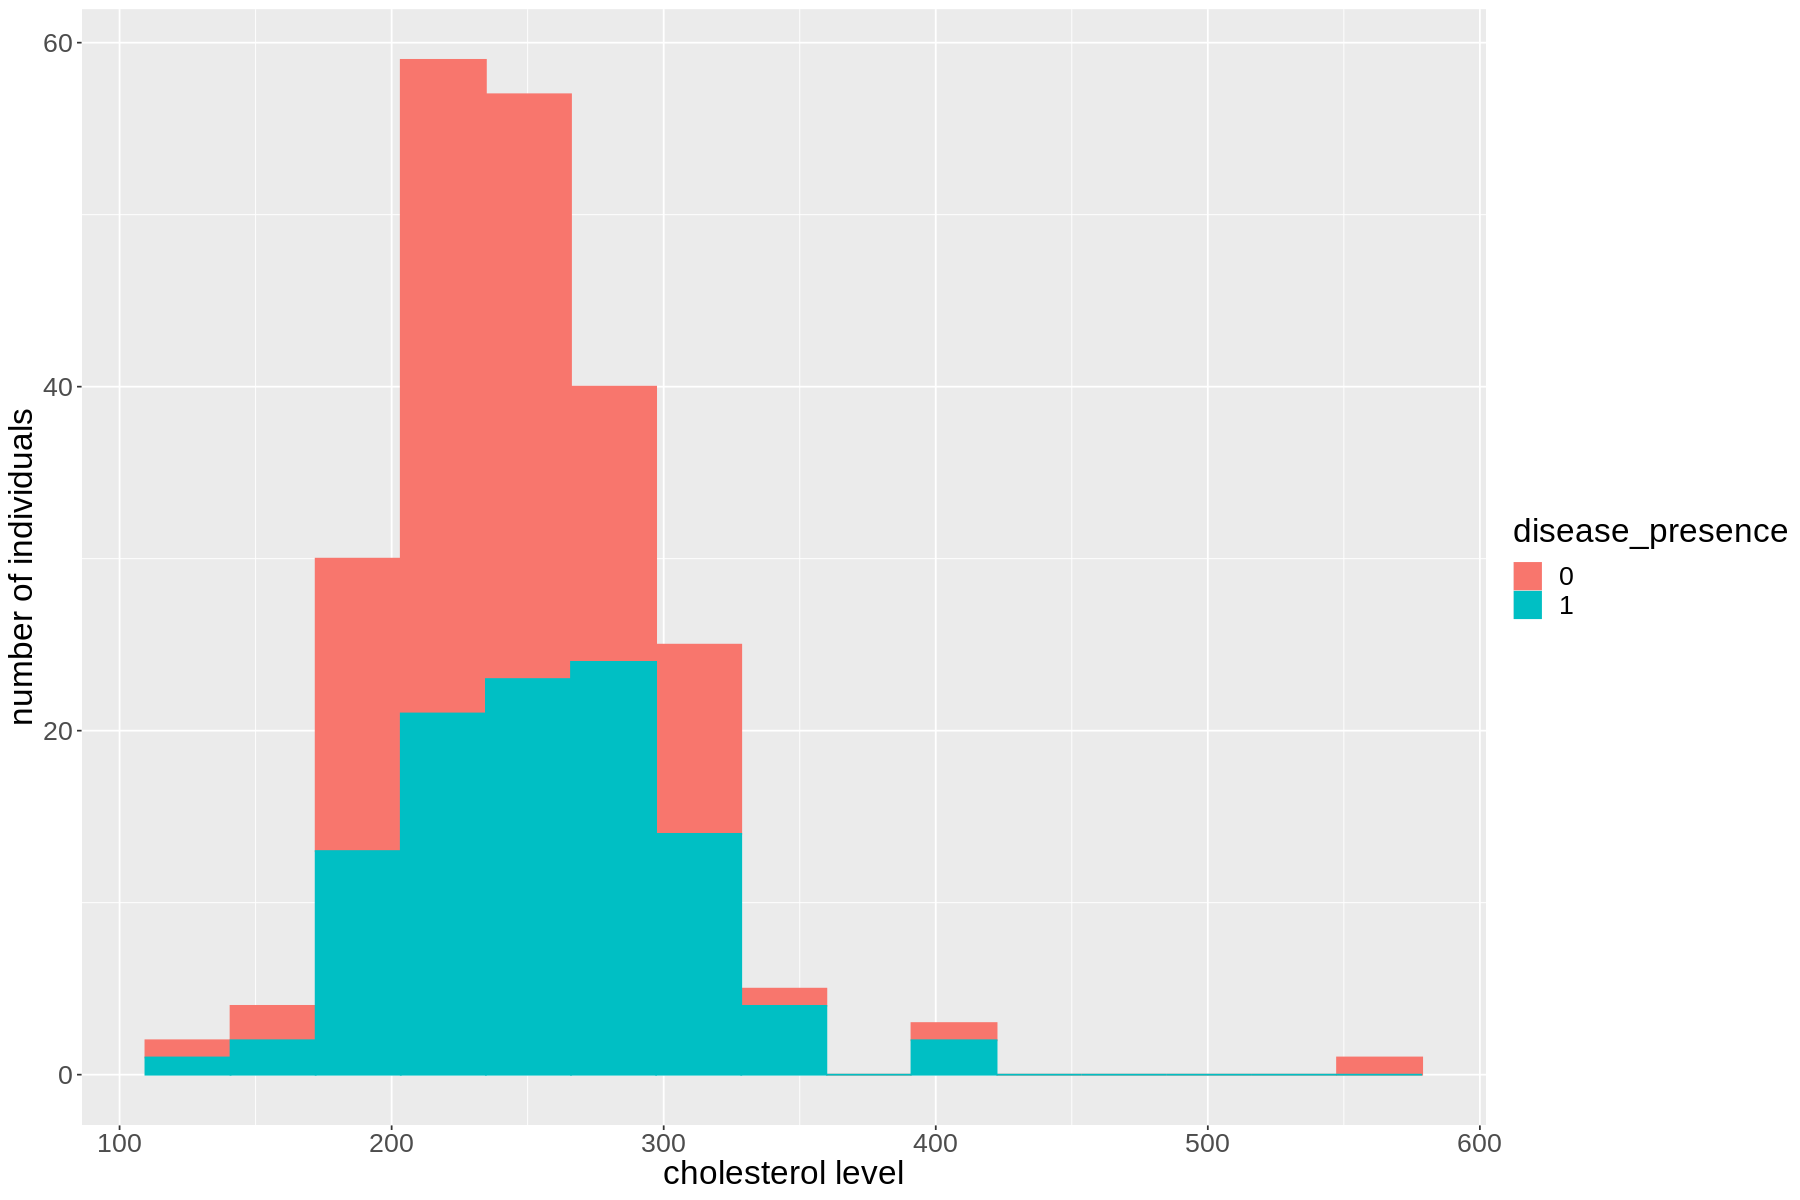

In [41]:
options(repr.plot.width = 15, repr.plot.height = 10)
disease.cholesterol_plot <- ggplot(disease_training, aes(x=cholesterol, fill=disease_presence, color=disease_presence)) +
          geom_histogram(bins=15)+
          xlab("cholesterol level") +
          ylab("number of individuals") + 
          theme(text = element_text(size = 20)) 
disease.cholesterol_plot

These graphs visualize the distribution of patient data and compare the ages, cholesterol levels, and blood pressure levels of individuals with and without heart disease.

# Method
Age, cholesterol level, and blood pressure level are our predictors because they are known factors in the development of heart disease. The older a patient is the higher the risk of heart disease becomes. The higher a patient's cholesterol or blood pressure levels, the more likely it is that their arteries or blood vessels can get damaged and clogged, which increases the risk of heart disease. 
But, when observing the three plots above we see that the presence of heart disease is more likely in patients as their age (especially above 55 years old), blood pressure (specifcally for levels above 160) and cholesterol levels (especially for values above 270) increase.

To analyze this data we will perform classification, following these steps:
- Create a K-nearest neighbor classifier with our three predictors and check the accuracy of the K-nearest neighbor found using vfold_cv.
- Create a model using the K-nearest neighbor to predict the presence or absence of heart disease in the patient and check for accuracy again, this time using the predict function and the testing data. 
- Create a visualization of our model, using scatterplots to visualize the relationship between two predictors at a time to visualize trends in predictors and their effect on the final diagnosis for a given patient. 


# Classification of Data

## Creation of Model and K-Nearest Neighbor Accuracy Check
To begin the classification we will need to create a KNN model to classify the data with our three predictors. The first step in doing this is to determine the $k$ value that will give us the most accurate predictions. Using our training data we will start by creating a tuning model and a recipe.

In [42]:
set.seed(2000)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_recipe <- recipe(disease_presence~age+blood_pressure+cholesterol, data = disease_training) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())

To find a $k$ value with high accuracy we can use cross-validation and then we can check the accuracy of the $k$-nearest neighbor found using `vfold_cv`. We will do this by testing 10 values of $k$ from 1 to 20, and then choose the one that gives the most accurate dataframe. 

In [43]:
fold <-vfold_cv (disease_training, v=10, strata = disease_presence)
k_values<-tibble(neighbors=seq(from=1, to=20, by=2))
best_k<-workflow()|>
    add_model(knn_spec_tune)|>
    add_recipe(knn_recipe)|>
    tune_grid(fold, grid = k_values)|>
    collect_metrics()

Now that we have our $k$ values. we will create a graph to visualize the $k$ value with the highest accuracy. 

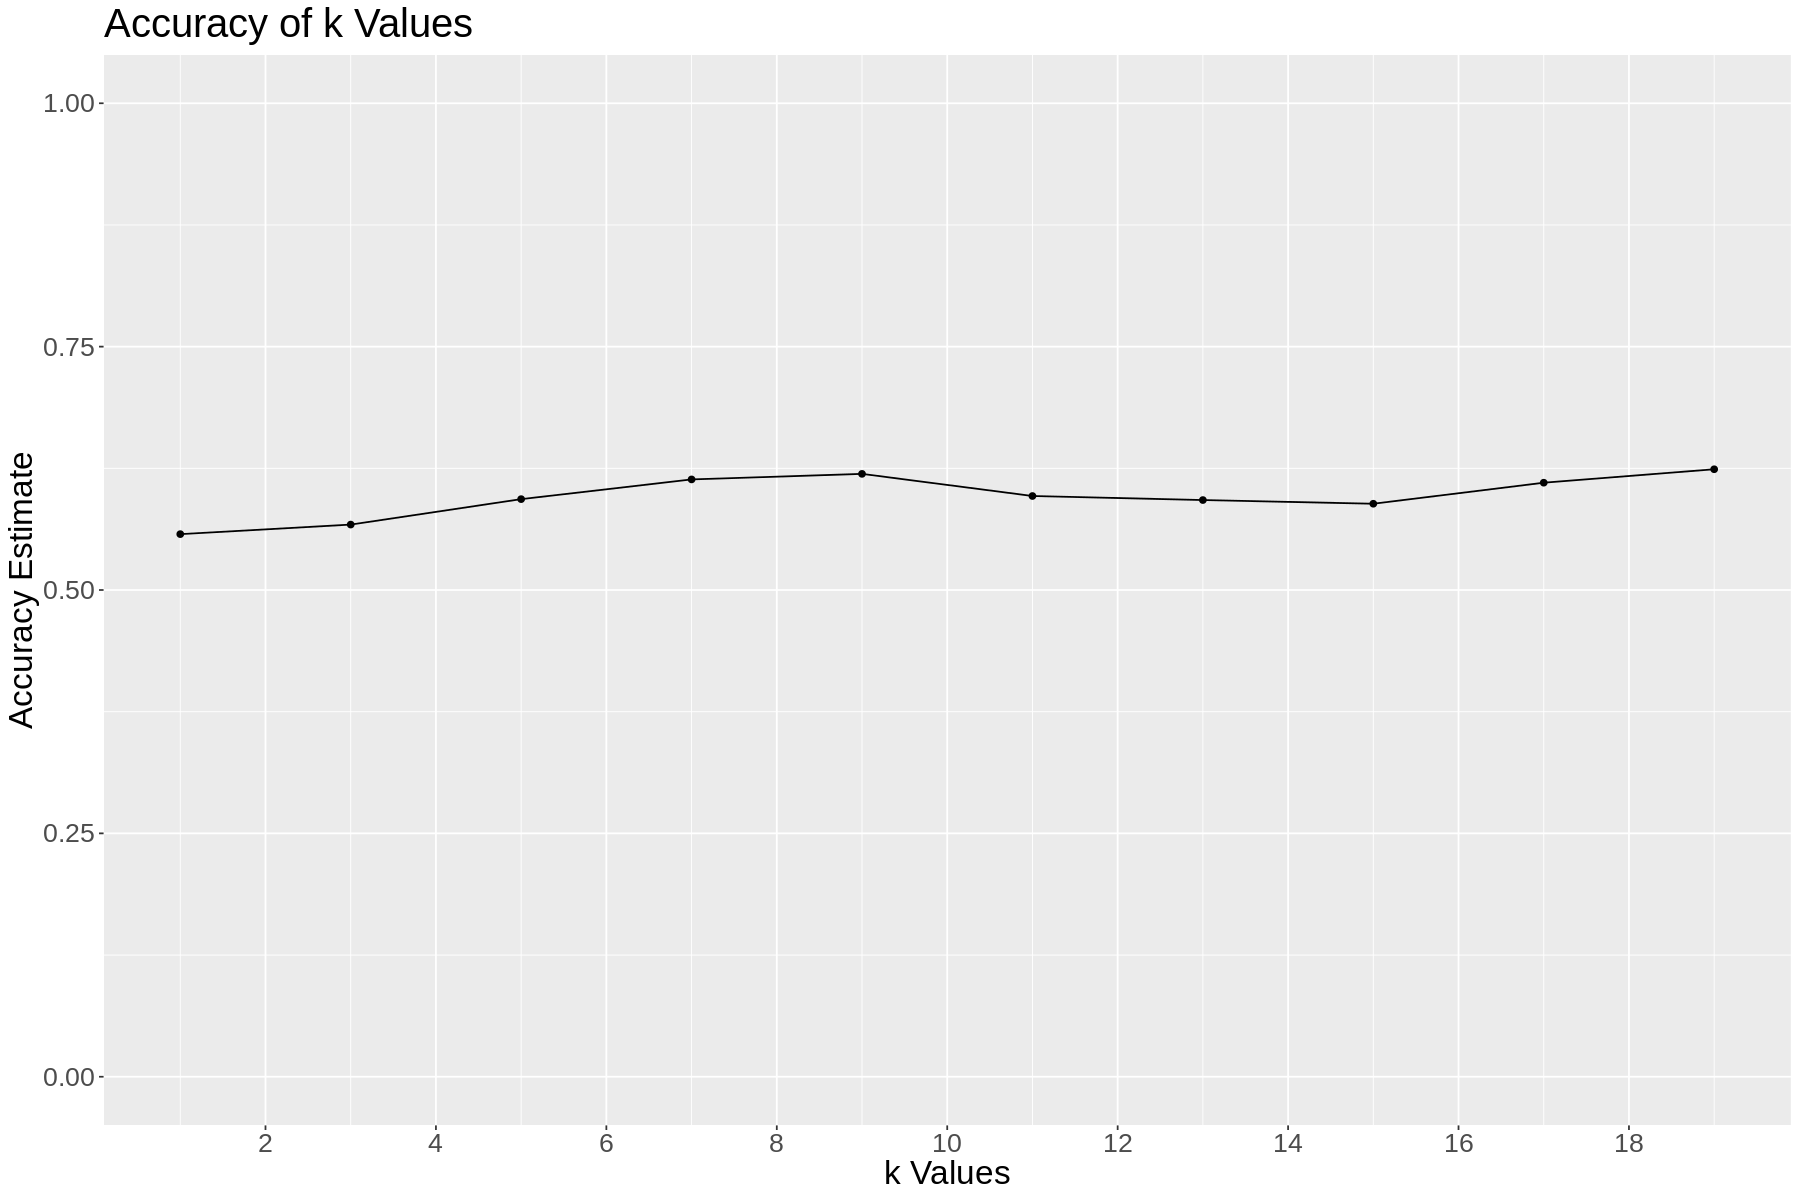

In [44]:
options(repr.plot.width = 15, repr.plot.height = 10)
accuracy_plot<-best_k|>
    filter(.metric == "accuracy")|>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(title = "Accuracy of k Values", x= "k Values", y= "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,20,by=2))+
    scale_y_continuous(limits = c(0,1.0))+
theme(text=element_text(size =20))
accuracy_plot

From the graph that plots the accuracy of the $k$ values, we can see that $k=19$ has the highest accuracy. To make sure we are right we can create a model that finds the $k$ value with the highest accuracy.

In [46]:
best_k_model<-best_k|>
    filter(.metric=='accuracy')|>
    filter(mean==max(mean))|>
    select(neighbors)|>
    pull()
best_k_model

[1] 19

Now that we have determined the best k value, k=19, we can create our final model using this k. 

In [47]:
knn_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
        set_engine("kknn") |>
        set_mode("classification")
knn_fit<- workflow() |>
         add_recipe(knn_recipe) |>
         add_model(knn_spec) |>
         fit(data = disease_training)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4026549
Best kernel: rectangular
Best k: 19

# Testing the Accuracy of Our Models Predictions 

Now that we have our final model, we can use it to predict whether or not heart disease is present in a patient.

In [48]:
prediction <- knn_fit |>
            predict(disease_testing) |>
            bind_cols(disease_testing)
head(prediction)

.pred_class,age,blood_pressure,cholesterol,disease_presence
<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,62,140,268,1
1,63,130,254,1
0,49,130,266,0
1,58,132,224,1
1,60,130,206,1
1,58,120,340,0


Using this, we can collect our metrics and see how accurate our classifier is.

In [49]:
accuracy<- prediction |>
        metrics(truth = disease_presence, estimate = .pred_class)
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6710526
kap,binary,0.3421053


This indicates to us that the accuracy of our classifier is roughly 67.1%.

# Visualizing Our Results
We can create a plot of the diagnosis v.s the prediction to understand how well the predictions match the actual presence of the disease in the data set. In this part we will only use the factors of age and blood pressure because in the exploratory data analysis section - the plots of our factors against number of patients and their diagnosis - they showed us a strong relationship with the presence of heart disease, whereas the distribution trend for cholesterol levels in patients with and without heart disease were very similar. Therfore we will disregard cholesterol levels in this section. 

In [50]:
options(repr.plot.width = 20, repr.plot.height = 10)
plot_pred_age_vs_blood_pressure<-prediction|>
    ggplot(aes(x=age, y = blood_pressure, color=.pred_class))+
    geom_point(size=6)+
    labs(x='Patients Age in Years', y='Patients Blood Pressure in mm', color='Diagnosis')+
    ggtitle('Prediction of Heart Disease (using age and blood pressure)')+
    theme(text=element_text(size=26))

We can make a column that tells us wether the prediction of the diagnosis is correct or not, so that we can create a plot to show the spots where the model made incorrect predictions.  

In [51]:
accuracy_column<- prediction |>
    mutate (equal = case_when(.pred_class == disease_presence ~ "correct", .pred_class !=disease_presence ~ "incorrect"))
head(accuracy_column)

.pred_class,age,blood_pressure,cholesterol,disease_presence,equal
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,62,140,268,1,correct
1,63,130,254,1,correct
0,49,130,266,0,correct
1,58,132,224,1,correct
1,60,130,206,1,correct
1,58,120,340,0,incorrect


Before we use this accuracy table to see whether the predictions of our model are correct, we can visually compare the actual diagnosis for heart disease on the age v.s cholesterol of patients plot, with a plot of the predictions that our model is making using the training data from the patients. 

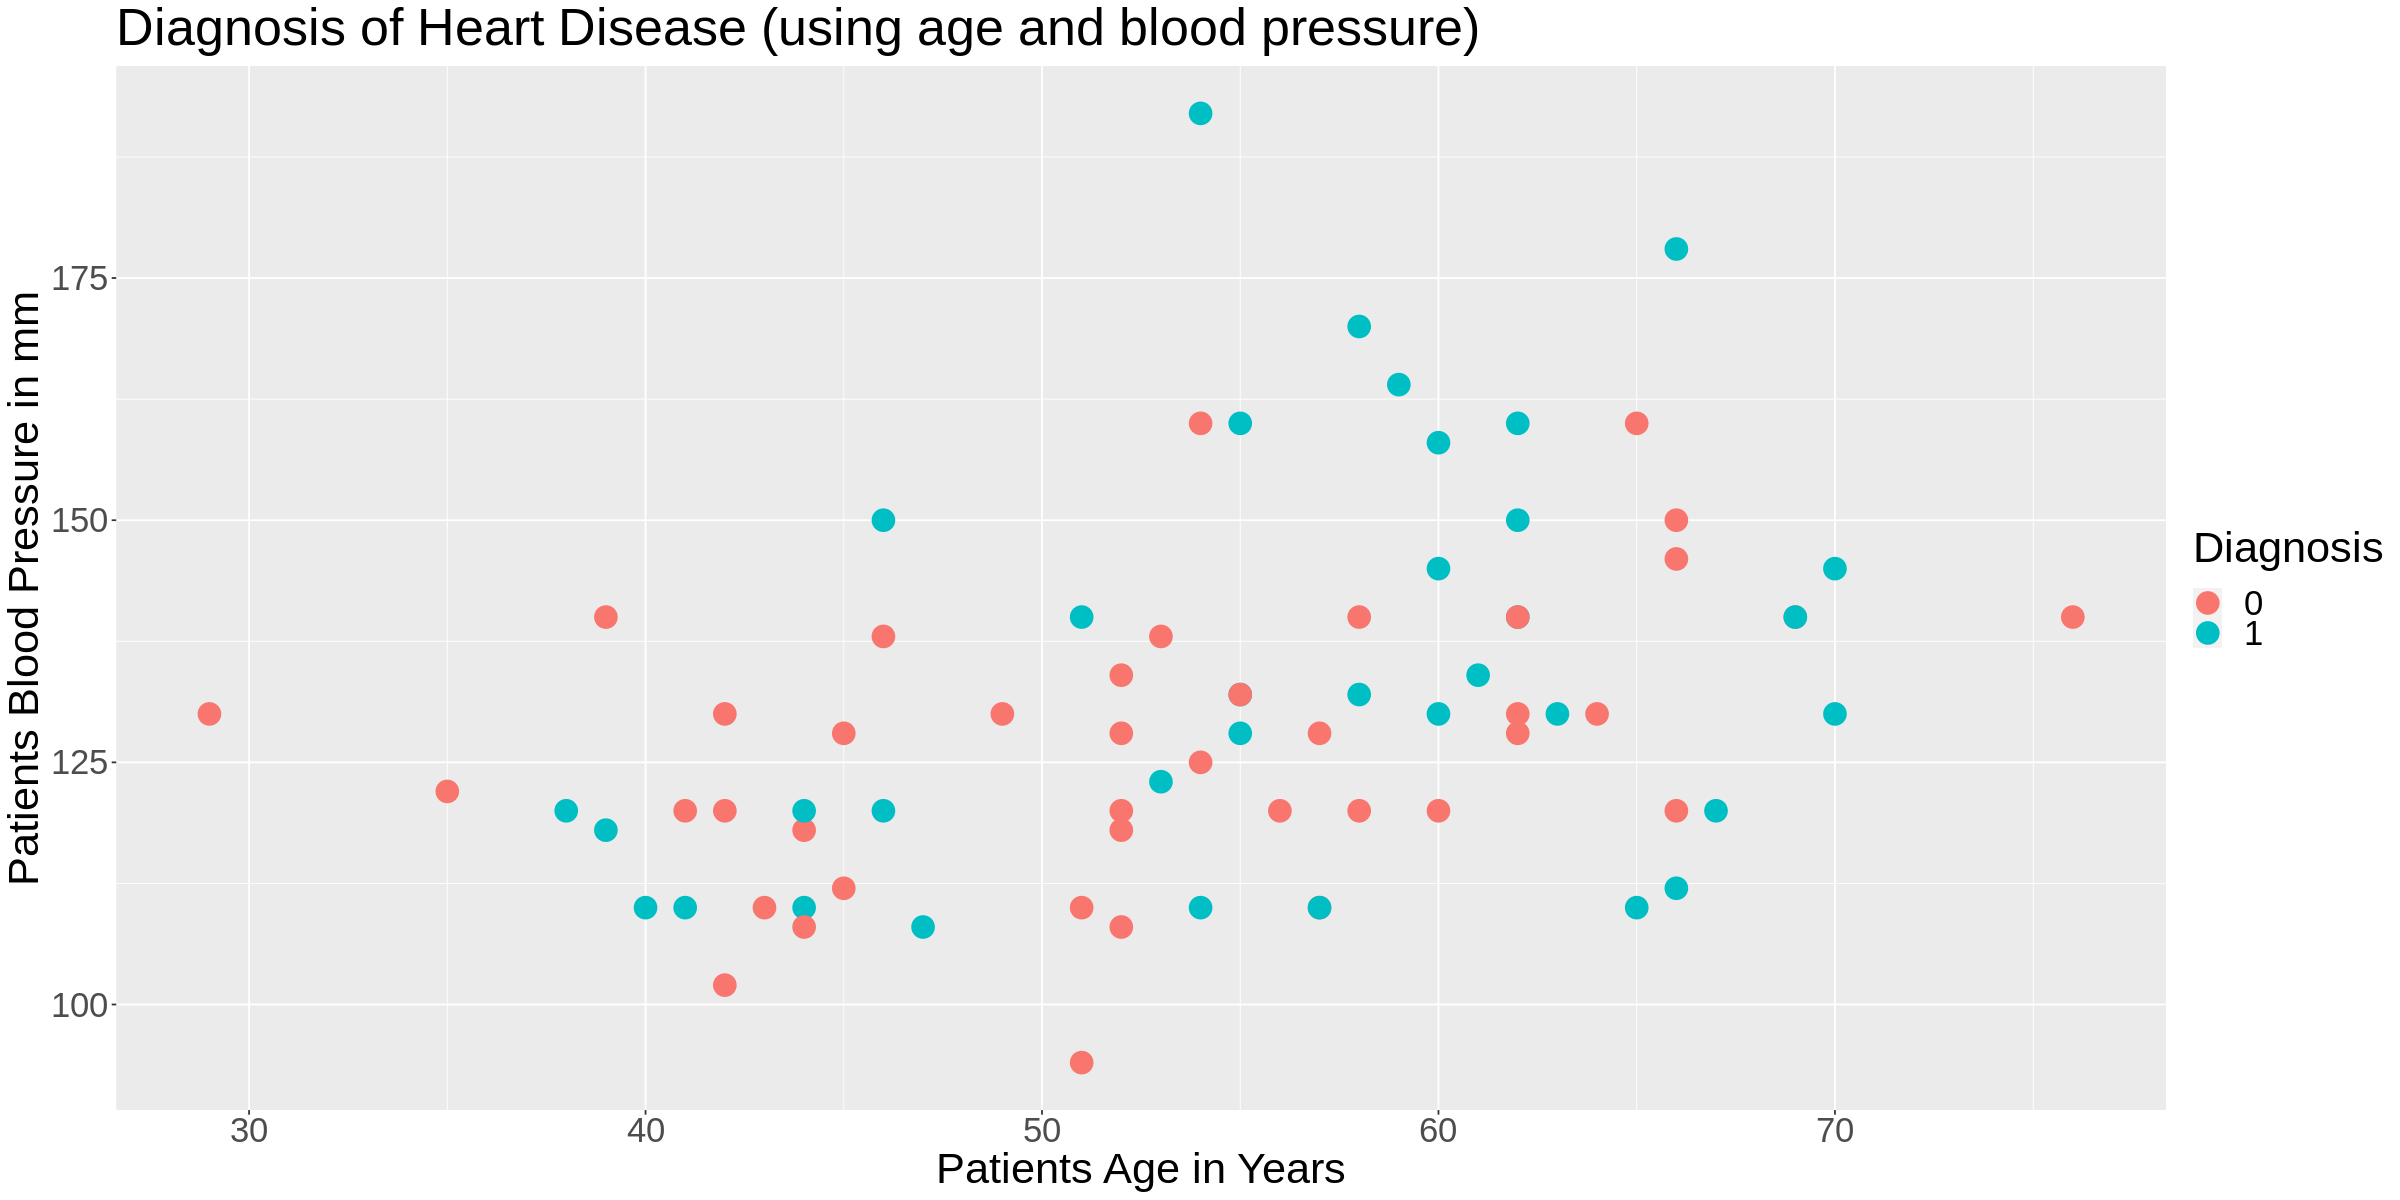

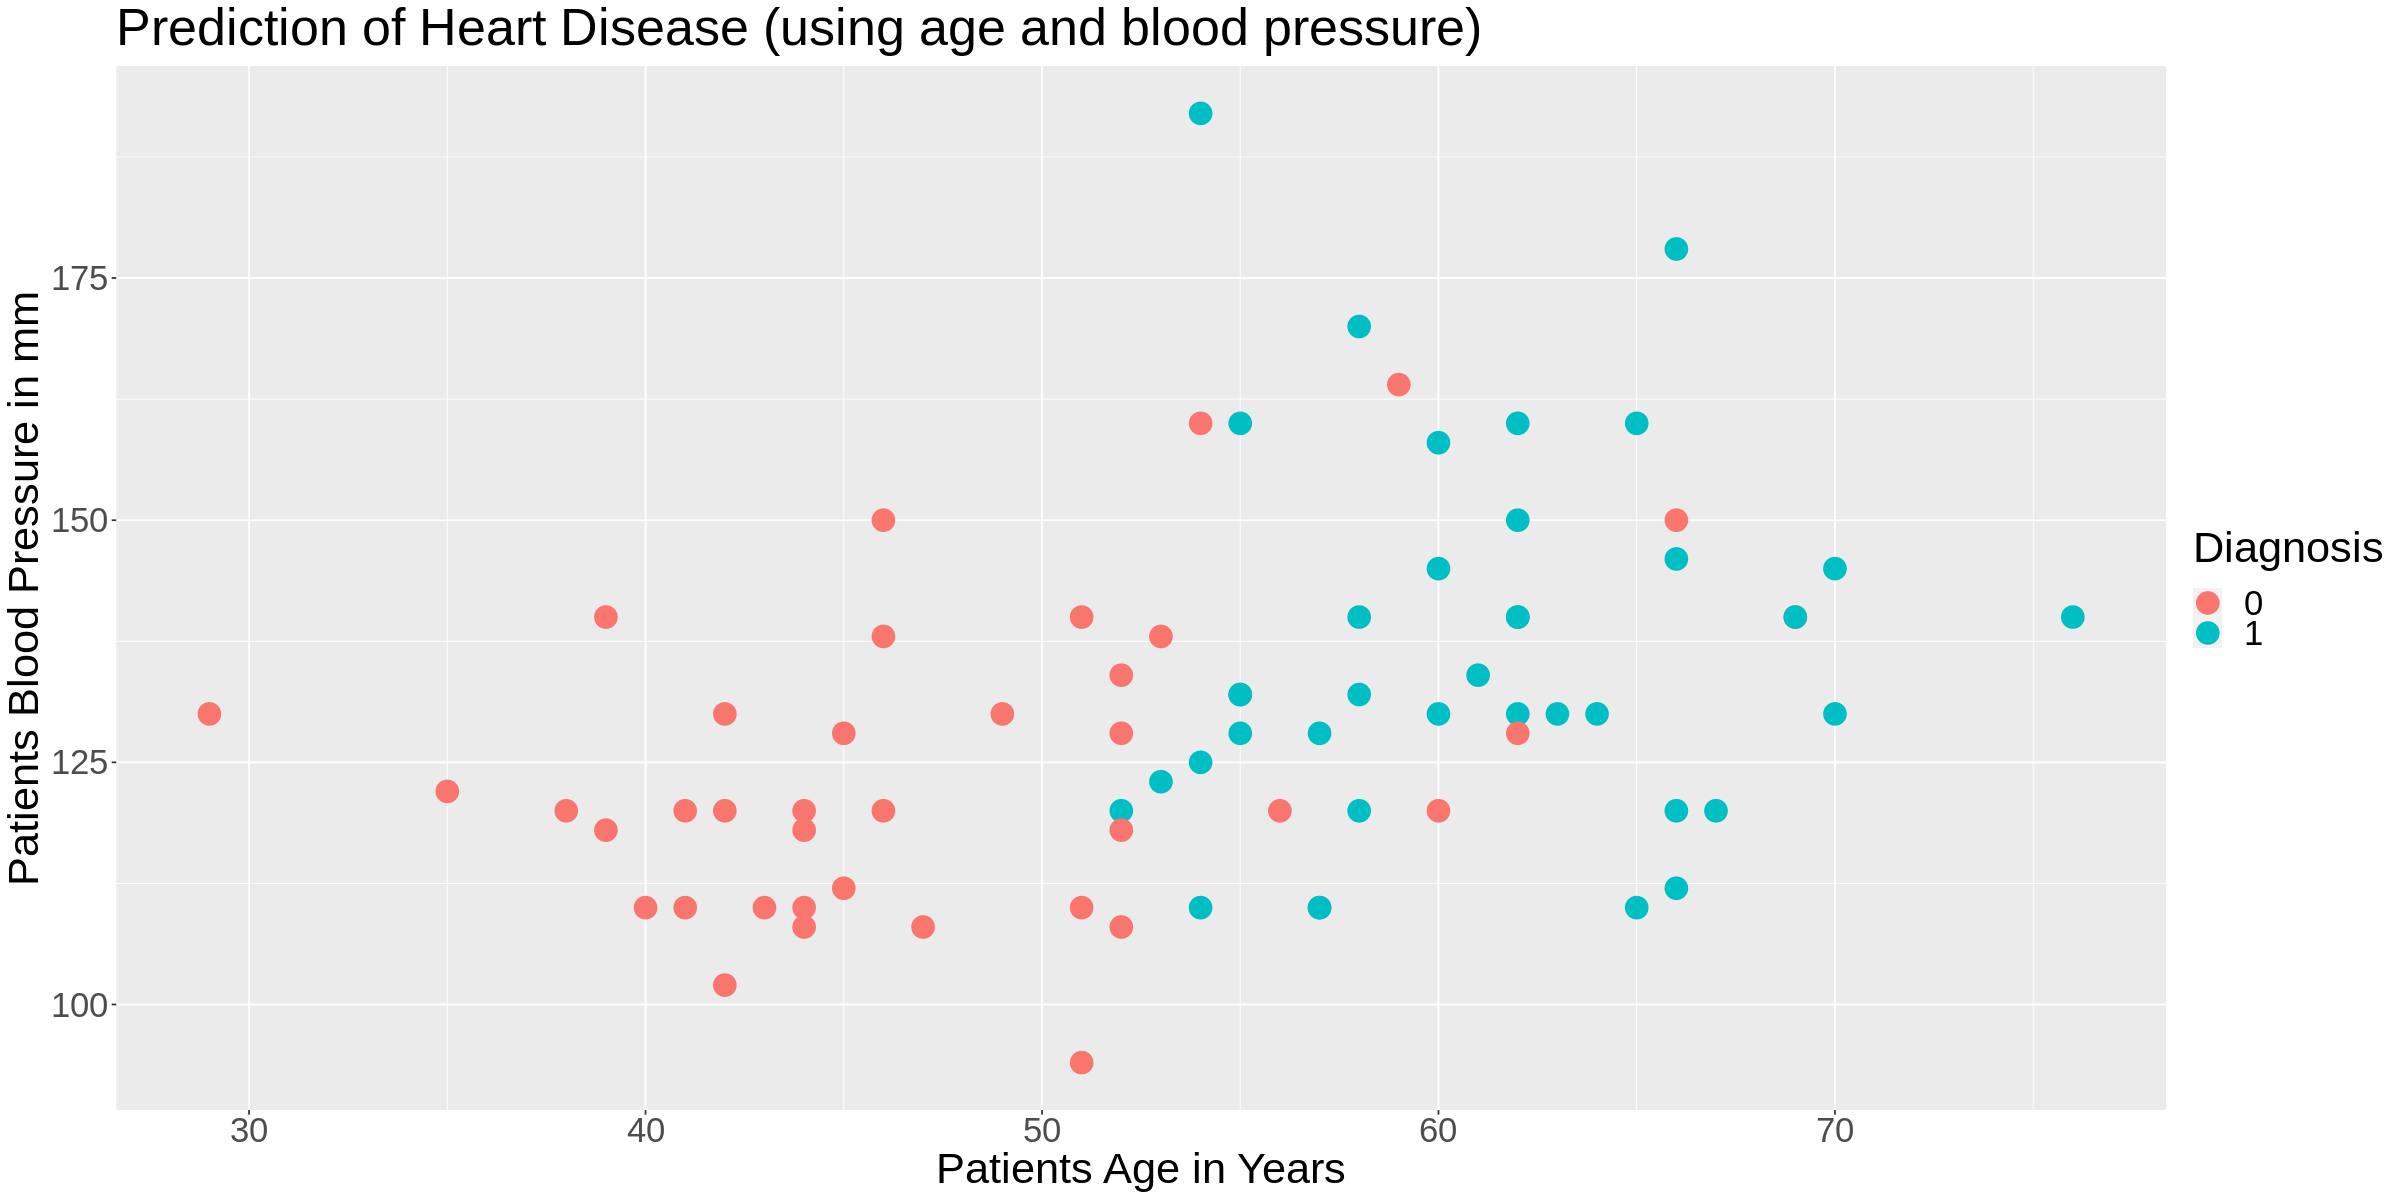

In [52]:
options(repr.plot.width = 20, repr.plot.height = 10)
testing_plot_age_vs_blood_pressure<-prediction|>
    ggplot(aes(x=age, y = blood_pressure, color=disease_presence))+
    geom_point(size=6)+
    labs(x='Patients Age in Years', y='Patients Blood Pressure in mm', color='Diagnosis')+
    ggtitle('Diagnosis of Heart Disease (using age and blood pressure)')+
    theme(text=element_text(size=26))
testing_plot_age_vs_blood_pressure
plot_pred_age_vs_blood_pressure

We can see that the two plots are quite different. The actual diagnosis plot doesn't show a strong relationship between a diagnosis and age and cholesterol levels, but the plot of the predictions of a diagnosis shows a strong relationship between the two factors and the diagnosis. 
To better understand how much error there is in our models predictions we can use the accuracy table we created to create a plot to visualise these errors, and to find the spots where the predictions were correct and where they weren't. 

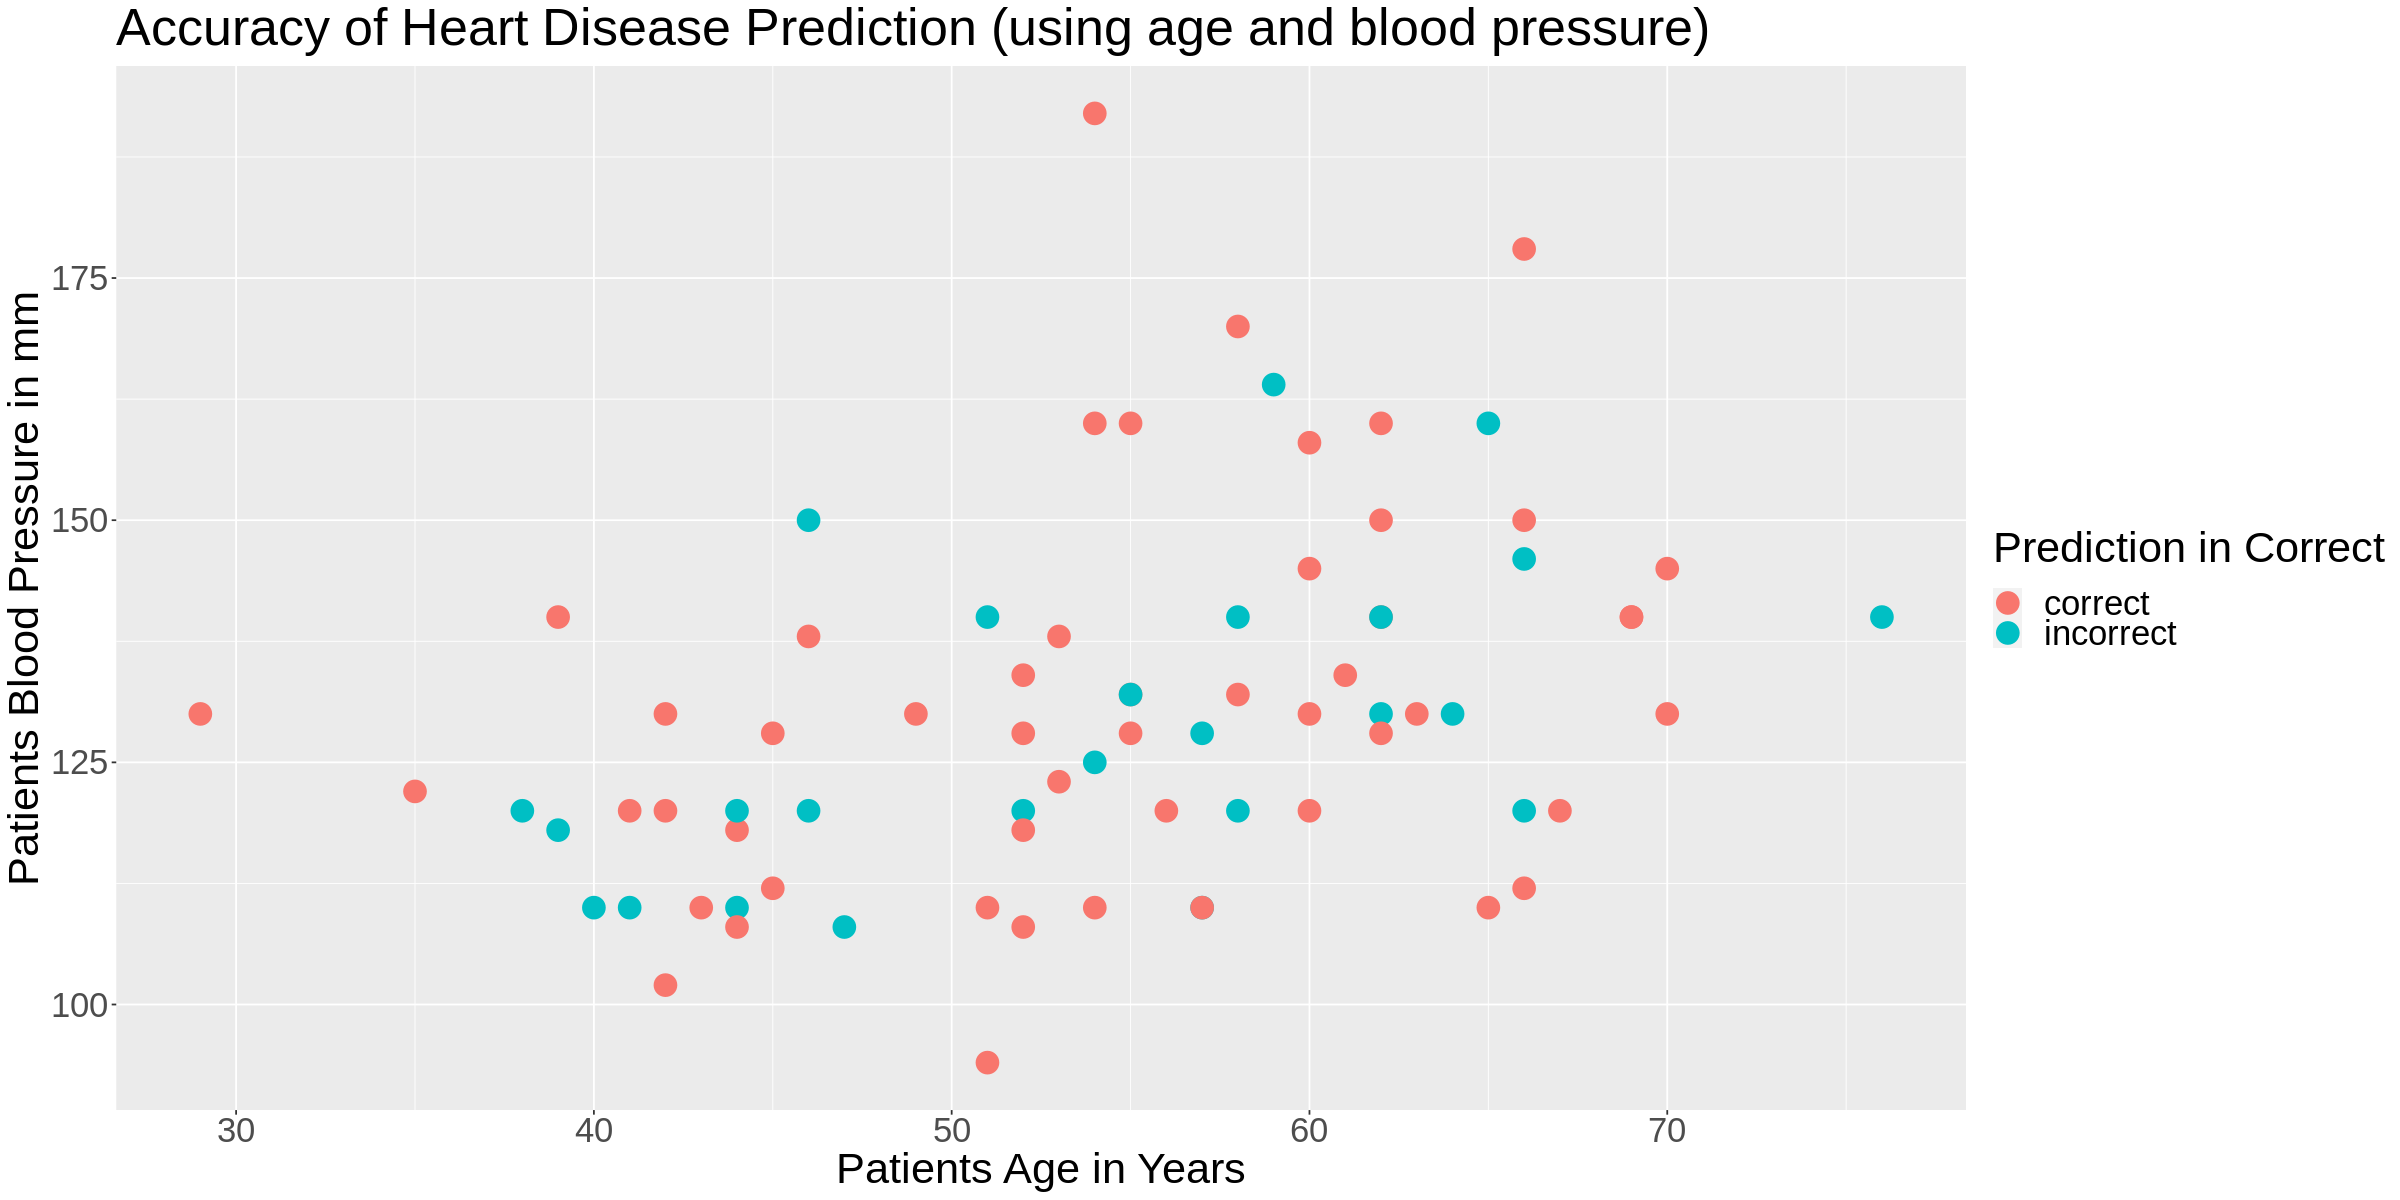

In [53]:
options(repr.plot.width = 20, repr.plot.height = 10)
diagnosis_vs_prediction<-accuracy_column|>
    ggplot(aes(x=age, y = blood_pressure, color=equal))+
    geom_point(size=6)+
    labs(x='Patients Age in Years', y='Patients Blood Pressure in mm', color='Prediction in Correct')+
    ggtitle('Accuracy of Heart Disease Prediction (using age and blood pressure)')+
    theme(text=element_text(size=26))
diagnosis_vs_prediction

This plot shows us that our model has the most difficulty predicting a correct diagnosis (the presence of heart disease) when a patient has low blood pressure (less then 160) which is coherent with what we were expecting from the plot we created in the exploratory data analysis section.

# Discussion of Results

Unfortunately, as we discovered, the accuracy of our classifier is not reliable enough for us to use it to predict the presence of heart disease in a patient, as it will only predict correctly 67% of the time. Additionally, the kappa coefficient is only 0.342. This suggests a low level of agreement between the classifier’s predictions and the real outcomes, meaning that the classifier’s performance is not significantly better than randomly guessing. Therefore, even though the classifier has an accuracy higher than 50%, the low kappa coefficient indicates that it is not effective at predicting outcomes. Reasons for this inaccuracy are likely due to other factors such as sex, medical history of family, and lifestyle to name a few that play an important role in an individuals health and likelyhood of developping the disease. 
Our visualisation allowed us to find that there is a strong relationship between blood pressure and the presence of heart disease and that a patient with high blood pressure above 160 mm Hg are very likely to be diagnosed with heart disease. Similarly, we also discovered that patients older then 55 are also more likely to be diagnosed. 
We were also able to deduce from the accuracy plot that the our model has an especially hard time providing an accurate diagnosis for patients with heart disease when they have low blood pressure or are young. 
Our classification model confirmed that we were right to think that these factors are helpful in predicting heart disease and that they should be evaluated to determine a patients diagnosis. However, our model still lacks accuracy because of the absence of other important factors. 

# Significance of Results

Heart disease research is important in helping us understand what kind of factors play into a person's heart disease or chances of getting heart disease, especially when we possess numerical values that can help us predict the presence of and even treat someone who may have heart disease. It's important to understand what kind of factors are affecting a person in the present so we can prevent any sort of health complications due to heart disease in the future. Things like this may include whether or not the patient smokes, whether or not the patient has diabetes, what kind of a diet the patient has, and so on. This leads to many questions that one could ponder for future research, like what kind of methods are the best at preventing heart disease? Such methods may be changing their diet, exercising, stress management, and many more that we could potentially analyze on a graph. Can we predict whether or not such methods will be successful in treating the patient? How much time does a patient have before their case gets severe enough to put their life at risk? All of these questions can help us further our research and better our understanding of the 

Sources: https://memorialhermann.org/services/specialties/heart-and-vascular/healthy-living/education/heart-disease-and-age , https://familyheart.org/cholesterol-is-key , https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html , https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset